In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [45]:
import torch
import numpy as np
import random

import matplotlib.pyplot as plt

In [46]:
seed = 0
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
 
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)


In [48]:
PHASE = 2

In [49]:
from data import DatasetFolder
from torch import nn
from torch.nn import functional as F
from torch.nn.init import calculate_gain
from torch.nn.modules.utils import _triple
from torch.nn.init import calculate_gain, _calculate_correct_fan, _calculate_fan_in_and_fan_out

In [50]:
size = 2 * 2 ** PHASE

In [51]:
dataset = DatasetFolder(f'/project/davidr/lidc_idri/npys/lanczos/{size}x{size}/', 
                               loader=lambda path: np.load(path),
                               extensions=('npy',),
                               transform=lambda x: torch.from_numpy(x))

In [52]:
def num_filters(phase, num_phases, base_dim):
    num_downscales = int(np.log2(base_dim / 16))
    filters = min(base_dim // (2 ** (phase - num_phases + num_downscales)), base_dim)
    return filters

In [53]:
def kaiming_normal_(tensor, gain_mode, mode='fan_in'):
    fan = _calculate_correct_fan(tensor, mode)
    gain = calculate_gain(gain_mode)
    std = gain / np.sqrt(fan)
    with torch.no_grad():
        tensor.normal_(0, 1)
#         print(f'Gain for {gain_mode}: {std:.3f}')
        return std

In [54]:
class EqualizedConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0):
        super(EqualizedConv3d, self).__init__()
        kernel_size = _triple(kernel_size)
        stride = _triple(stride)
        padding = _triple(padding)
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        self.weight = nn.Parameter(torch.Tensor(
                out_channels, in_channels, *kernel_size))
        self.bias = nn.Parameter(torch.Tensor(out_channels))
        
        self.std = None  # Placeholder
        self.reset_parameters()

    def reset_parameters(self):
        self.std = kaiming_normal_(self.weight, 'conv3d')
        if self.bias is not None:
            fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / np.sqrt(fan_in)
            torch.nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        return F.conv3d(input, self.weight * self.std, self.bias, self.stride,
                        self.padding)


In [55]:
class EqualizedLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(EqualizedLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = nn.Parameter(torch.zeros(out_features))
        self.std = None  # Placeholder
        self.reset_parameters()

    def reset_parameters(self):
        self.std = kaiming_normal_(self.weight, 'linear')
        if self.bias is not None:
            fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / np.sqrt(fan_in)
            torch.nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        return F.linear(input, self.weight * self.std, self.bias)


In [56]:
class DiscriminatorBlock(nn.Sequential):
    def __init__(self, filters_in, filters_out):
        super(DiscriminatorBlock, self).__init__()
        
        self.conv1 = EqualizedConv3d(filters_in, filters_in, 3, padding=1)
        self.conv2 = EqualizedConv3d(filters_in, filters_out, 3, padding=1)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2)
        self.downsampling = nn.AvgPool3d(2)
    
    def forward(self, input):
        x = self.conv1(input)
        x = self.lrelu(x)
        x = self.conv2(x)
        x = self.lrelu(x)
        x = self.downsampling(x)
        return x
        
        

In [57]:
class FromRGB(nn.Sequential):
    def __init__(self, channels_in, filters):
        super(FromRGB, self).__init__()
        self.fromrgb = nn.Sequential(
            EqualizedConv3d(channels_in, filters, 1),
            nn.LeakyReLU(negative_slope=0.2)
        )
    
    def forward(self, input):
        return self.fromrgb(input)


In [58]:
class MinibatchStandardDeviation(nn.Module):
    def __init__(self, group_size=4):
        super(MinibatchStandardDeviation, self).__init__()
        self.group_size = group_size
        
    def forward(self, input):
        group_size = min(self.group_size, input.shape[0])
        if group_size < len(input):
            for i in range(group_size, len(input) + 1):
                if len(input) % i == 0:
                    group_size = i
                    break
        
        s = input.shape
        y = input.view([group_size, -1, s[1], s[2], s[3], s[4]])
        y -= torch.mean(y, dim=0, keepdim=True)                     
        y = torch.mean(y ** 2, dim=0)                           
        y = torch.sqrt(y + 1e-8)
        y = torch.mean(y, dim=[1, 2, 3, 4], keepdim=True)
        y = y.repeat([group_size, 1, s[2], s[3], s[4]])
        return torch.cat([input, y], dim=1)           

In [59]:
MinibatchStandardDeviation()(torch.randn(21, 256, 2, 8, 8)).shape

torch.Size([21, 257, 2, 8, 8])

In [60]:
train_sampler = torch.utils.data.distributed.DistributedSampler(
    dataset, num_replicas=4, rank=0)
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4,
sampler=train_sampler, num_workers=4, pin_memory=True)


In [61]:
data_loader.sampler.set_epoch(0)

In [62]:
class Discriminator(nn.Module):
    def __init__(self, phase, num_phases, base_dim, latent_dim, base_shape):
        super(Discriminator, self).__init__()
        self.channels = base_shape[0]
        self.base_shape = base_shape[1:]
        
        self.phase = phase
        self.fromrgbs = nn.ModuleDict()
        filters_out = num_filters(phase, num_phases, base_dim)
        self.fromrgbs[f'from_rgb_{phase}'] = FromRGB(self.channels, filters_out)

        
        self.blocks = nn.ModuleDict()
        for i in reversed(range(1, phase)):
            filters_in = num_filters(i + 1, num_phases, base_dim)
            filters_out = num_filters(i, num_phases, base_dim)
            self.blocks[f'discriminator_block_{i + 1}'] = DiscriminatorBlock(filters_in, filters_out)
            self.fromrgbs[f'from_rgb_{i}'] = FromRGB(self.channels, filters_out)
        
        self.downscale = nn.AvgPool3d(2)
            
        self.discriminator_out = nn.Sequential(
            MinibatchStandardDeviation(),
            EqualizedConv3d(filters_out + 1, base_dim, 3, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Flatten(),
            EqualizedLinear(np.product(self.base_shape) * base_dim, latent_dim),
            nn.LeakyReLU(negative_slope=0.2),
            EqualizedLinear(latent_dim, 1)
        )
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
    
    
    def forward(self, input, alpha=0):
        
        input = input.to(self.device)
        
        x_downscale = input.clone()
        
        x = self.fromrgbs[f'from_rgb_{self.phase}'](input)
                                
        for i in reversed(range(1, self.phase)):
            x = self.blocks[f'discriminator_block_{i + 1}'](x)
            
            x_downscale = self.downscale(x_downscale)
            fromrgb_prev = self.fromrgbs[f'from_rgb_{i}'](x_downscale)
            x = alpha * fromrgb_prev + (1 - alpha) * x
            
        x = self.discriminator_out(x)
        return x
            

        
            
        

In [63]:
class Discriminator(nn.Module):
    def __init__(self, phase, num_phases, base_dim, latent_dim, base_shape):
        super(Discriminator, self).__init__()
        self.channels = base_shape[0]
        self.base_shape = base_shape[1:]
        
        self.phase = phase
        self.fromrgbs = nn.ModuleDict()
        filters_out = num_filters(phase, num_phases, base_dim)
        self.fromrgbs[f'from_rgb_{phase}'] = FromRGB(self.channels, filters_out)
        filters_out_prev = num_filters(phase - 1, num_phases, base_dim)
        self.fromrgbs[f'from_rgb_{phase - 1}'] = FromRGB(self.channels, filters_out_prev)

        self.blocks = nn.ModuleDict()
        for i in reversed(range(1, phase)):
            filters_in = num_filters(i + 1, num_phases, base_dim)
            filters_out = num_filters(i, num_phases, base_dim)
            self.blocks[f'discriminator_block_{i + 1}'] = DiscriminatorBlock(filters_in, filters_out)
        
        self.downscale = nn.AvgPool3d(2)
            
        self.discriminator_out = nn.Sequential(
            MinibatchStandardDeviation(),
            EqualizedConv3d(filters_out + 1, base_dim, 3, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Flatten(),
            EqualizedLinear(np.product(self.base_shape) * base_dim, latent_dim),
            nn.LeakyReLU(negative_slope=0.2),
            EqualizedLinear(latent_dim, 1)
        )
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
    
    
    def forward(self, input, alpha=0):
        
        input = input.to(self.device)
                
        x = self.fromrgbs[f'from_rgb_{self.phase}'](input)
                                
        for i in reversed(range(1, self.phase)):
            x = self.blocks[f'discriminator_block_{i + 1}'](x)
            
            if i == self.phase - 1:
                x_downscale = self.downscale(input)
                fromrgb_prev = self.fromrgbs[f'from_rgb_{i}'](x_downscale)
                x = alpha * fromrgb_prev + (1 - alpha) * x
            
        x = self.discriminator_out(x)
        return x
            
            
        

In [64]:
discriminator = Discriminator(PHASE, 8, 256, 256, (1, 1, 4, 4))


In [65]:
discriminator(torch.randn(1, 1, 1, 4, 4))

RuntimeError: input image (T: 1 H: 4 W: 4) smaller than kernel size (kT: 2 kH: 2 kW: 2)

In [66]:
sum(p.numel() for p in discriminator.parameters())

6366209

In [67]:
class ChannelNormalization(nn.Module):
    def __init__(self):
        super(ChannelNormalization, self).__init__()

    def forward(self, input):
        return input * torch.rsqrt(torch.mean(input ** 2, dim=1, keepdim=True) + 1e-8)


In [68]:
class GeneratorBlock(nn.Sequential):
    def __init__(self, filters_in, filters_out):
        super(GeneratorBlock, self).__init__()
        self.upsampling = nn.Upsample(scale_factor=2)
        self.conv1 = EqualizedConv3d(filters_in, filters_out, 3, padding=1)
        self.conv2 = EqualizedConv3d(filters_out, filters_out, 3, padding=1)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2)
        self.cn = ChannelNormalization()
    
    def forward(self, input):
        x = self.upsampling(input)
        x = self.conv1(x)
        x = self.lrelu(x)
        x = self.cn(x)
        x = self.conv2(x)
        x = self.cn(x)
        x = self.lrelu(x)
        return x
        
        


In [69]:
class ToRGB(nn.Sequential):
    def __init__(self, filters_in, channels):
        super(ToRGB, self).__init__()
        self.conv = EqualizedConv3d(filters_in, channels, 1)
        
    def forward(self, input):
        return self.conv(input)

In [70]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, input):
        return torch.reshape(input, self.shape)

In [71]:
class Generator(nn.Module):
    def __init__(self, phase, num_phases, base_dim, latent_dim, base_shape):
        super(Generator, self).__init__()
        
        self.channels = base_shape[0]
        self.base_shape = base_shape[1:]
        self.phase = phase
        self.latent_dim = latent_dim
        filters = base_dim
        self.generator_in = nn.Sequential(
            EqualizedLinear(latent_dim, np.product(self.base_shape) * filters),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            Reshape([-1, filters] + list(self.base_shape)),
            EqualizedConv3d(filters, filters, 3, padding=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            ChannelNormalization(),
        )
        
        self.to_rgb_1 = ToRGB(filters, self.channels)
        
        self.blocks = nn.ModuleDict()
        self.to_rgbs = nn.ModuleDict()
        
        for i in range(1, phase):
            filters_in = num_filters(i, num_phases, base_dim)
            filters_out = num_filters(i + 1, num_phases, base_dim)
            self.blocks[f'generator_block_{i + 1}'] = GeneratorBlock(filters_in, filters_out)
            self.to_rgbs[f'to_rgb_{i + 1}'] = ToRGB(filters_out, self.channels)
            
        self.upsample = nn.Upsample(scale_factor=2)
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
                
    def forward(self, input, alpha=0):
        input = input.to(self.device)
        
        x = self.generator_in(input)
        
        images_out = self.to_rgb_1(x)
                
        for i in range(1, self.phase):
            x = self.blocks[f'generator_block_{i + 1}'](x)
            img_gen = self.to_rgbs[f'to_rgb_{i + 1}'](x)
            images_out = alpha * (self.upsample(images_out)) + (1 - alpha) * img_gen
    
        return images_out

In [72]:
generator = Generator(PHASE, 8, 256, 256, (1, 1, 4, 4))

In [73]:
out = generator(torch.randn(1, 256), alpha=1)

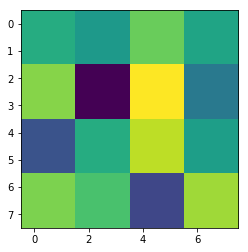

In [74]:
plt.imshow(out[0, 0, 0].detach().cpu().numpy())

In [94]:
class Generator(nn.Module):
    def __init__(self, phase, num_phases, base_dim, latent_dim, base_shape):
        super(Generator, self).__init__()
        
        self.channels = base_shape[0]
        self.base_shape = base_shape[1:]
        self.phase = phase
        self.latent_dim = latent_dim
        filters = base_dim
        self.generator_in = nn.Sequential(
            EqualizedLinear(latent_dim, np.product(self.base_shape) * filters),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            Reshape([-1, filters] + list(self.base_shape)),
            EqualizedConv3d(filters, filters, 3, padding=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            ChannelNormalization(),
        )
         
        self.blocks = nn.ModuleDict()
        
        for i in range(1, phase):
            filters_in = num_filters(i, num_phases, base_dim)
            filters_out = num_filters(i + 1, num_phases, base_dim)
            self.blocks[f'generator_block_{i + 1}'] = GeneratorBlock(filters_in, filters_out)
        
        self.to_rgbs = nn.ModuleDict()
        filters_phase = num_filters(phase, num_phases, base_dim)
        self.to_rgbs[f'to_rgb_{phase}'] = ToRGB(filters_phase, self.channels)
        
        if phase > 1:
            filters_prev_phase = num_filters(phase - 1, num_phases, base_dim)
            self.to_rgbs[f'to_rgb_{phase - 1}'] = ToRGB(filters_prev_phase, self.channels)
        

        self.upsample = nn.Upsample(scale_factor=2)
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
                
    def forward(self, input, alpha=0):
        input = input.to(self.device)
        
        x = self.generator_in(input)
        
        x_upsampled = None
        for i in range(1, self.phase):
            
            if i == self.phase - 1:
                x_upsampled = self.to_rgbs[f'to_rgb_{i}'](self.upsample(x))
            
            x = self.blocks[f'generator_block_{i + 1}'](x)
            
        x = self.to_rgbs[f'to_rgb_{self.phase}'](x)
        
        if x_upsampled is not None:
            x = alpha * x_upsampled + (1 - alpha) * x
    
        return x

In [95]:
generator = Generator(PHASE, 8, 256, 256, (1, 1, 4, 4))

In [96]:
out = generator(torch.randn(1, 256), alpha=1)

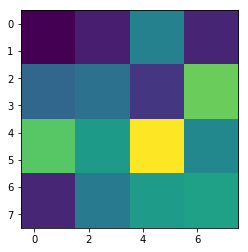

In [97]:
plt.imshow(out[0, 0, 0].detach().cpu().numpy())

In [98]:
d_optim = torch.optim.Adam(discriminator.parameters(), betas=(0, 0.9))
g_optim = torch.optim.Adam(generator.parameters(), betas=(0, 0.9))

In [99]:
d_optim.param_groups[0]['lr']

0.001

In [100]:
data_loader = torch.utils.data.DataLoader(dataset, 
                                          batch_size=64,
                                          num_workers=4,
                                          pin_memory=True)

In [101]:
def wasserstein_loss(y_pred):
    return y_pred.mean()

In [102]:
def gradient_penalty_loss(y_pred, 
                          averaged_samples,
                          gradient_penalty_weight=10):
    
    grad_outputs = torch.ones_like(y_pred).to(y_pred.device)
    gradients = torch.autograd.grad(
        y_pred, 
        inputs=averaged_samples,
        grad_outputs=grad_outputs,
        create_graph=True, 
        retain_graph=True)[0]
    
    gradients_sqr = gradients ** 2
    gradients_sqr_sum = torch.sum(gradients_sqr, 
                                  dim=tuple(range(1, len(gradients_sqr.shape))))
    gradient_l2_norm = torch.sqrt(gradients_sqr_sum)
    gradient_penalty = gradient_penalty_weight * (1 - gradient_l2_norm) ** 2
    return torch.mean(gradient_penalty)


In [103]:
def compute_gradient_penalty(discriminator, real_samples, fake_samples, gradient_penalty_weight=10):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand(real_samples.shape[0], 1, 1, 1, 1).to(real_samples.device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = discriminator(interpolates)
    fake = torch.autograd.Variable(torch.Tensor(real_samples.shape[0], 1).fill_(1.0).to(real_samples.device), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty * gradient_penalty_weight


In [104]:
import matplotlib.pyplot as plt

In [108]:
def train_epoch(data_loader, generator, discriminator, generator_optim, discriminator_optim, alpha):
    
    d_losses = []
    g_losses = []
    
    for i, x_real in enumerate(data_loader):
        
        # Train discriminator.
        generator.eval()
        for p in generator.parameters():
            p.requires_grad = False
 
        discriminator.train()
        for p in discriminator.parameters():
            p.requires_grad = True
        
        x_real = x_real.to(discriminator.device)
        z = torch.randn(x_real.shape[0], generator.latent_dim)
        x_fake = generator(z, alpha)
        
        d_real = discriminator(x_real, alpha)
        d_fake = discriminator(x_fake, alpha)
                
        gp_loss = compute_gradient_penalty(discriminator, x_real, x_fake)
        real_loss = wasserstein_loss(d_real)
        fake_loss = wasserstein_loss(d_fake)
        
        d_loss = -real_loss + fake_loss + gp_loss
        
        discriminator_optim.zero_grad()
        d_loss.backward()
        discriminator_optim.step()
        
        d_losses.append(d_loss.item())
        
        # Train generator.
        generator.train()
        for p in generator.parameters():
            p.requires_grad = True
            
        discriminator.eval()
        for p in discriminator.parameters():
            p.requires_grad = False
        
        z = torch.randn(x_real.shape[0], generator.latent_dim)
        x_fake = generator(z, alpha)
        
        d_fake = discriminator(x_fake, alpha)
        g_loss = -wasserstein_loss(d_fake)
        
        generator_optim.zero_grad()
        g_loss.backward()
        generator_optim.step()
        
        g_losses.append(g_loss.item())
        
        if i % 50 == 0:
            print(g_loss.item(), d_loss.item())
           
    print("Real")
    print(x_real.shape)
    plt.imshow(x_real[0, 0, 0].squeeze().cpu().detach().numpy())
    plt.show()

    print("Fake")
    plt.imshow(x_fake[0, 0, 0].squeeze().cpu().detach().numpy())
    plt.show()          
    return np.mean(d_losses), np.mean(g_losses)
        

3.162031888961792 -2.821462631225586
Real
torch.Size([34, 1, 2, 8, 8])


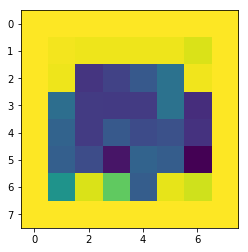

Fake


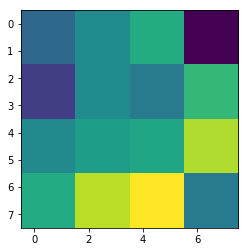

3.005953311920166 -2.748819589614868
Real
torch.Size([34, 1, 2, 8, 8])


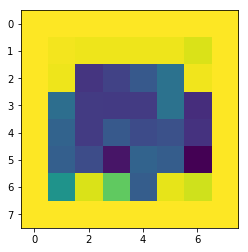

Fake


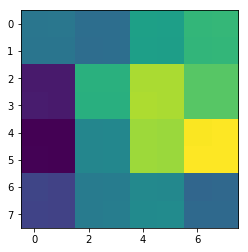

2.465611696243286 -2.5282070636749268
Real
torch.Size([34, 1, 2, 8, 8])


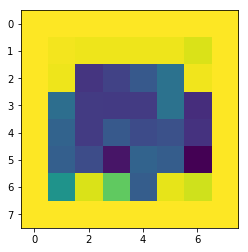

Fake


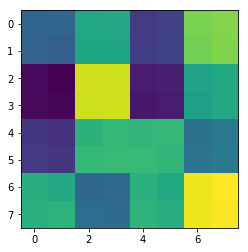

2.164504051208496 -2.1910295486450195
Real
torch.Size([34, 1, 2, 8, 8])


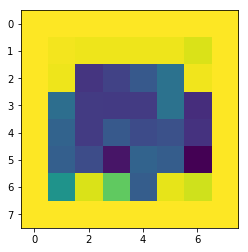

Fake


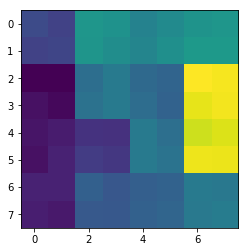

1.4623857736587524 -1.8781487941741943
Real
torch.Size([34, 1, 2, 8, 8])


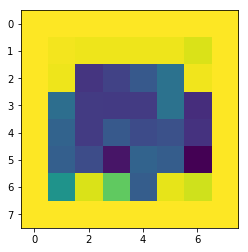

Fake


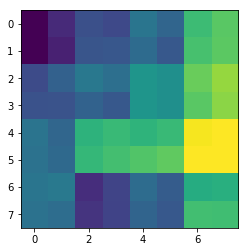

1.4339405298233032 -1.2380995750427246
Real
torch.Size([34, 1, 2, 8, 8])


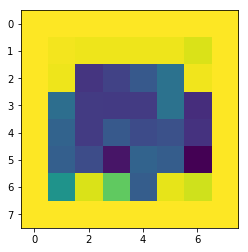

Fake


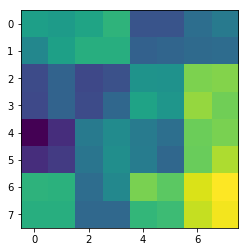

1.002324104309082 -0.6854583024978638
Real
torch.Size([34, 1, 2, 8, 8])


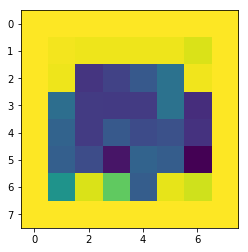

Fake


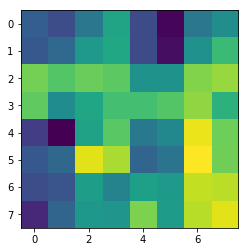

0.6972416043281555 -0.17487353086471558
Real
torch.Size([34, 1, 2, 8, 8])


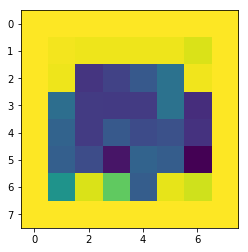

Fake


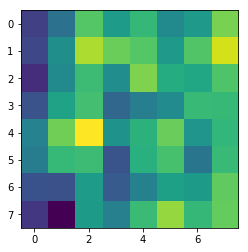

0.377705454826355 0.04115144908428192
Real
torch.Size([34, 1, 2, 8, 8])


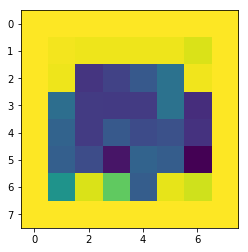

Fake


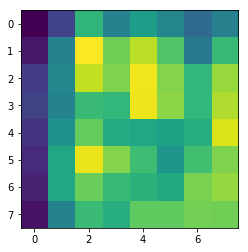

0.5594747066497803 0.2357550412416458
Real
torch.Size([34, 1, 2, 8, 8])


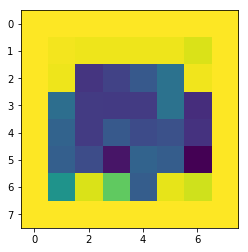

Fake


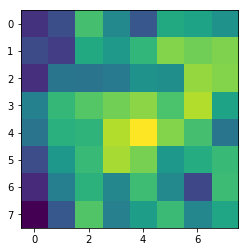

1.1499214172363281 0.380930632352829
Real
torch.Size([34, 1, 2, 8, 8])


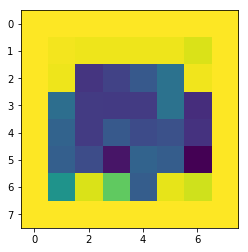

Fake


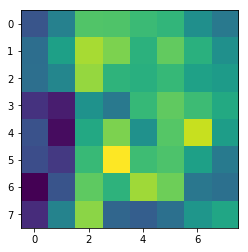

1.6154881715774536 0.4889317750930786
Real
torch.Size([34, 1, 2, 8, 8])


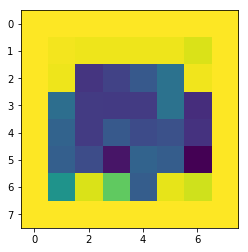

Fake


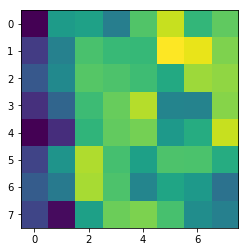

1.812070608139038 0.37023264169692993
Real
torch.Size([34, 1, 2, 8, 8])


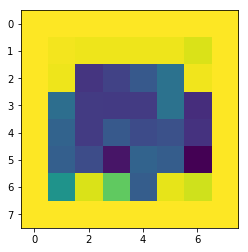

Fake


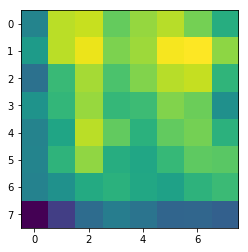

1.8410543203353882 0.39313262701034546
Real
torch.Size([34, 1, 2, 8, 8])


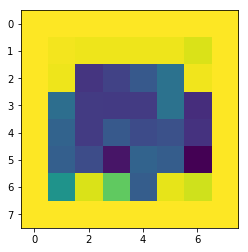

Fake


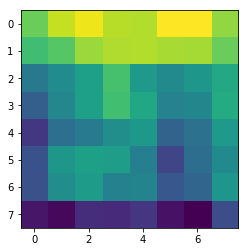

1.6955569982528687 0.40398019552230835
Real
torch.Size([34, 1, 2, 8, 8])


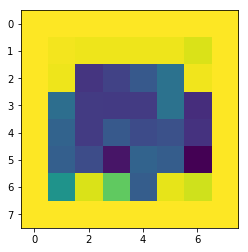

Fake


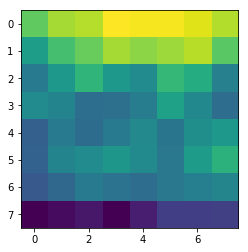

1.4788479804992676 0.1068481057882309
Real
torch.Size([34, 1, 2, 8, 8])


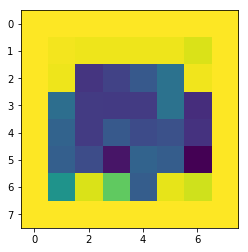

Fake


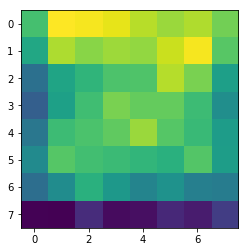

1.6479216814041138 0.10160398483276367
Real
torch.Size([34, 1, 2, 8, 8])


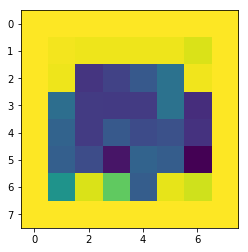

Fake


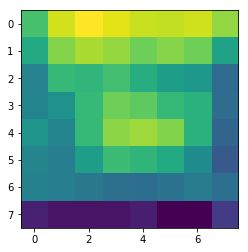

1.7030458450317383 0.17691698670387268
Real
torch.Size([34, 1, 2, 8, 8])


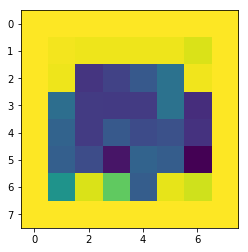

Fake


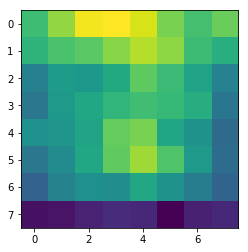

1.6357269287109375 0.2214590609073639
Real
torch.Size([34, 1, 2, 8, 8])


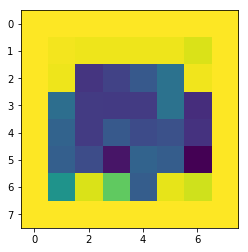

Fake


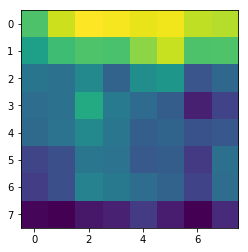

1.6892191171646118 0.194422647356987
Real
torch.Size([34, 1, 2, 8, 8])


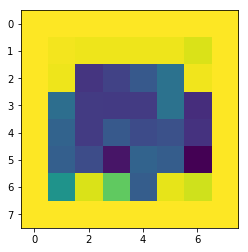

Fake


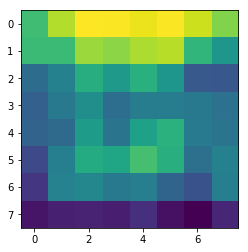

1.6160191297531128 0.21060433983802795
Real
torch.Size([34, 1, 2, 8, 8])


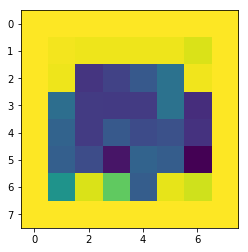

Fake


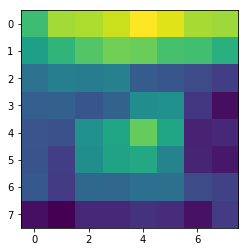

1.5604406595230103 0.25460296869277954
Real
torch.Size([34, 1, 2, 8, 8])


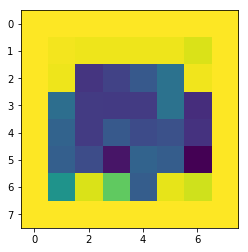

Fake


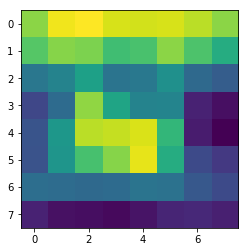

1.3889923095703125 0.18649886548519135
Real
torch.Size([34, 1, 2, 8, 8])


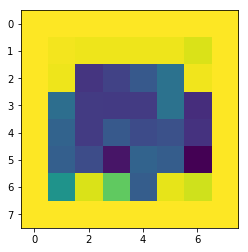

Fake


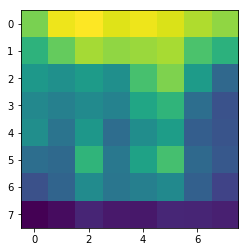

1.2394134998321533 0.1650281548500061
Real
torch.Size([34, 1, 2, 8, 8])


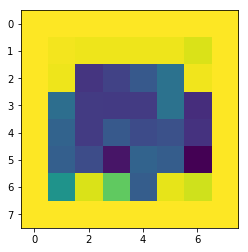

Fake


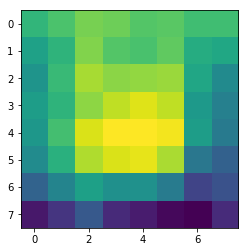

1.1336817741394043 0.25417307019233704
Real
torch.Size([34, 1, 2, 8, 8])


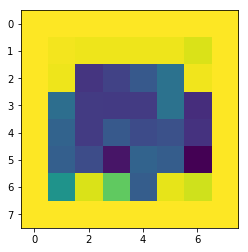

Fake


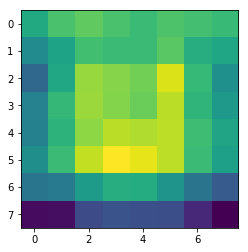

0.9713714718818665 0.14403371512889862
Real
torch.Size([34, 1, 2, 8, 8])


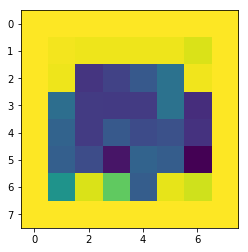

Fake


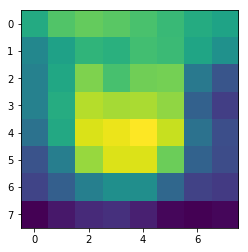

0.9893209934234619 0.18429185450077057
Real
torch.Size([34, 1, 2, 8, 8])


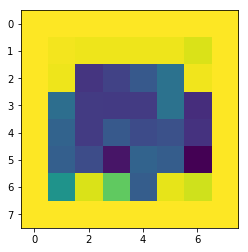

Fake


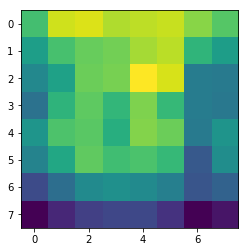

0.9659277200698853 0.12955528497695923
Real
torch.Size([34, 1, 2, 8, 8])


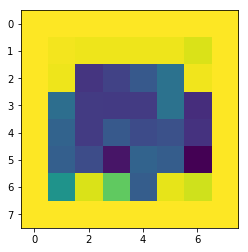

Fake


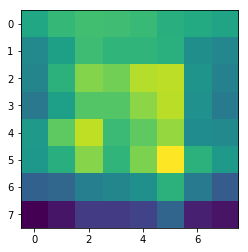

1.1019093990325928 0.08278122544288635
Real
torch.Size([34, 1, 2, 8, 8])


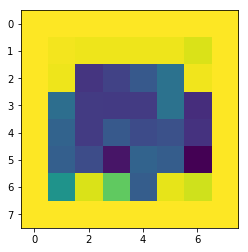

Fake


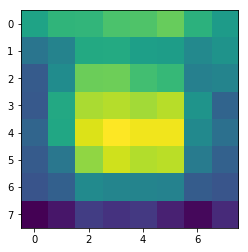

1.1157591342926025 0.16808977723121643
Real
torch.Size([34, 1, 2, 8, 8])


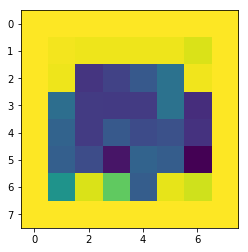

Fake


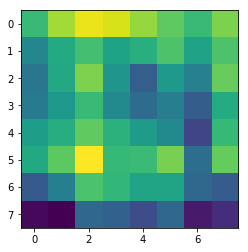

1.1154265403747559 0.28798583149909973
Real
torch.Size([34, 1, 2, 8, 8])


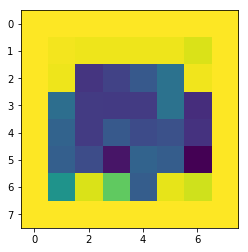

Fake


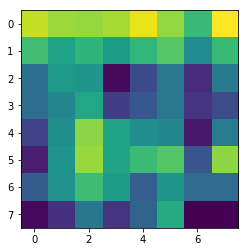

1.0744483470916748 0.37837058305740356
Real
torch.Size([34, 1, 2, 8, 8])


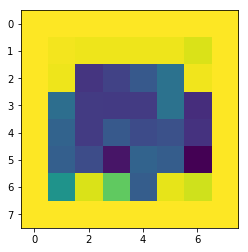

Fake


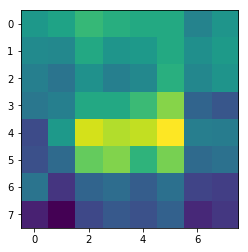

1.0611132383346558 0.08703333139419556
Real
torch.Size([34, 1, 2, 8, 8])


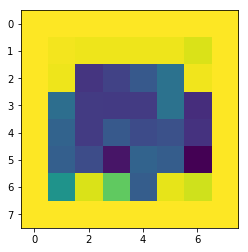

Fake


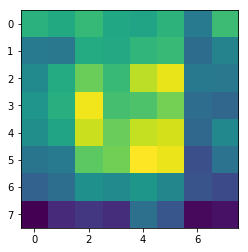

0.9806353449821472 0.14115682244300842
Real
torch.Size([34, 1, 2, 8, 8])


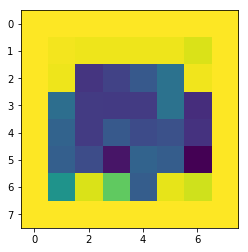

Fake


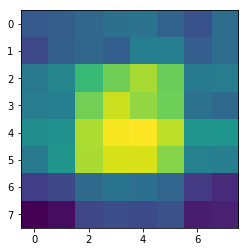

0.9520139694213867 0.1932997703552246
Real
torch.Size([34, 1, 2, 8, 8])


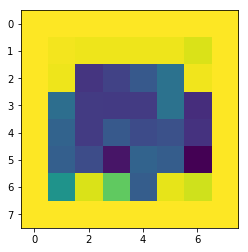

Fake


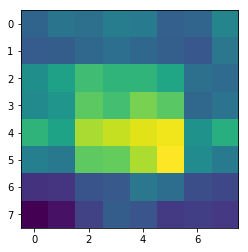

0.8995815515518188 0.23201441764831543
Real
torch.Size([34, 1, 2, 8, 8])


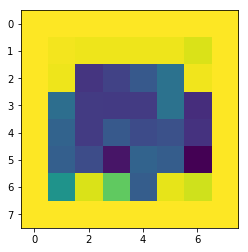

Fake


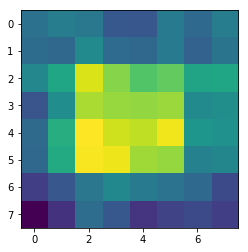

0.9371410608291626 0.1859988272190094
Real
torch.Size([34, 1, 2, 8, 8])


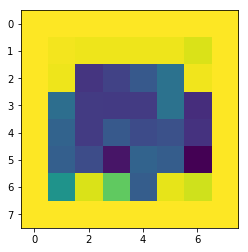

Fake


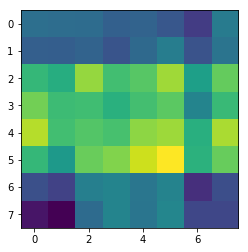

0.9789963960647583 0.2635017931461334
Real
torch.Size([34, 1, 2, 8, 8])


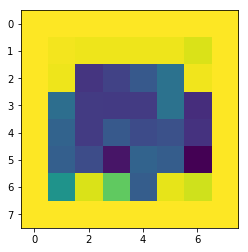

Fake


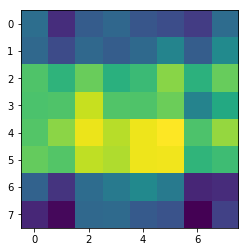

0.9361304640769958 0.1524527668952942
Real
torch.Size([34, 1, 2, 8, 8])


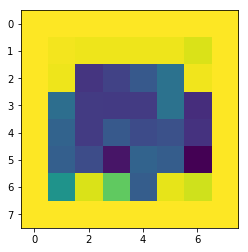

Fake


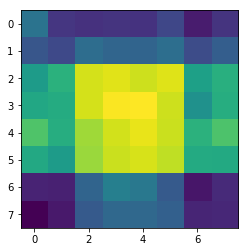

0.8455828428268433 0.20577865839004517
Real
torch.Size([34, 1, 2, 8, 8])


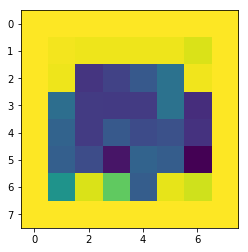

Fake


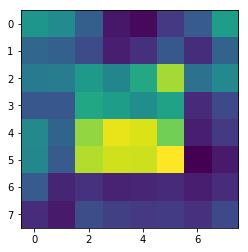

0.7241207361221313 0.19550836086273193


KeyboardInterrupt: 

In [109]:
alpha = 1
for i in range(100):
    train_epoch(data_loader, generator, discriminator, g_optim, d_optim, alpha=alpha)
    alpha = alpha - .01